# MCMC: Logistic Regression

Main References:
 - [1] https://github.com/WillKoehrsen/ai-projects/blob/master/markov_chain_monte_carlo/markov_chain_monte_carlo.ipynb
 - [2] https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98


In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

import json

# Creating the sample data

A logistic function with some Gaussian noise around it. 

In [2]:
np.random.seed(0)

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))


beta = 1
alpha = 0

sigma = 0.1
mu = 0
N_SAMPLES = 1000

x = np.linspace(-100,100,N_SAMPLES)
noise = np.random.normal(mu,sigma,N_SAMPLES)

logistic_series = logistic(x,beta,alpha)

noisy_series  = noise+logistic_series

Plots:

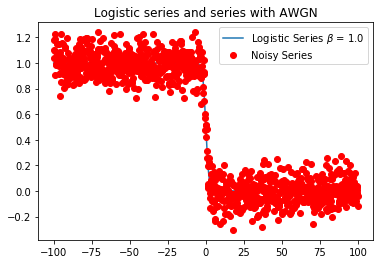

In [3]:
plt.plot(x, logistic_series, label = r"Logistic Series $\beta$ = %.1f" % beta)
plt.plot(x, noisy_series, 'ro',label = r"Noisy Series")

plt.legend();
plt.title(r'Logistic series and series with AWGN');


# Bayesian Parameter Estimation based on a Logistic Model

In [4]:
observations = noisy_series

In [5]:
with pm.Model() as MCMC_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0, tau=50, testval=0.0)
    beta = pm.Normal('beta', mu=1.5, tau=5, testval=0.0)
    
    # Create the probability from the logistic function
    log_fn = pm.Deterministic('log_fn', 1. / (1. + tt.exp(beta * x + alpha)))
    
    
    
    
    
    
    # Starting values are found through Maximum A Posterior estimation
    #start = pm.find_MAP()
    obs = pm.Normal('obs', log_fn, sigma=sigma, observed=observations)
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    model_trace = pm.sample(N_SAMPLES, step=step);
        

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5773.26draws/s]
The number of effective samples is smaller than 25% for some parameters.


# Posteriors for $\alpha$ and $\beta$

In [6]:
alpha_samples =model_trace["alpha"][N_SAMPLES:, None]
beta_samples = model_trace["beta"][N_SAMPLES:, None]

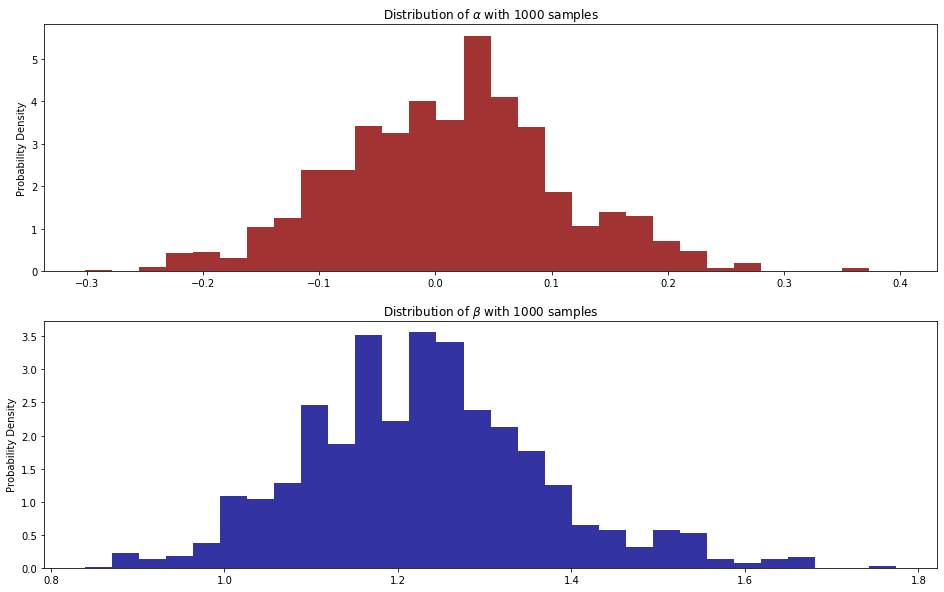

In [7]:
figsize(16, 10)

plt.subplot(211)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\beta$ with %d samples""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

In [8]:
print(alpha_samples.mean())
print(beta_samples.mean())

0.012145453470030636
1.2313306318527033


# Visualizing the Posterior Model Probability

In [9]:
alpha_post = alpha_samples.mean()
beta_post = beta_samples.mean()

prob_est = logistic(x,beta_post, alpha_post)

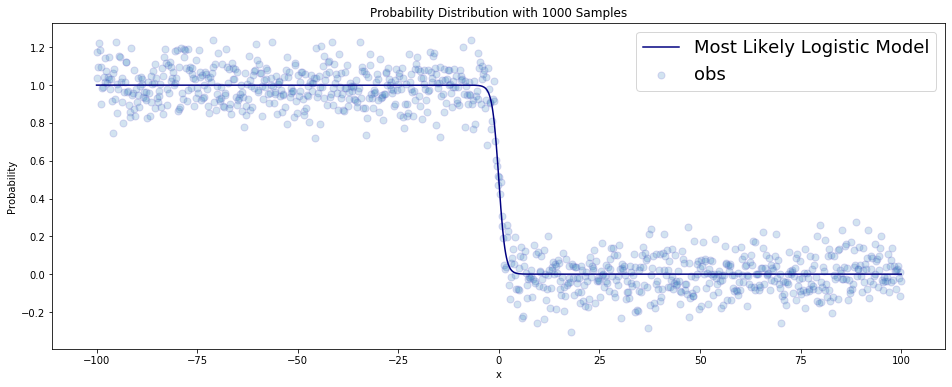

In [10]:

figsize(16, 6)

plt.plot(x, prob_est, color = 'navy',  label="Most Likely Logistic Model")
plt.scatter(x, noisy_series, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.title('Probability Distribution with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':18})
plt.ylabel('Probability')
plt.xlabel('x');



### Incorporating Confidence Intervals

In [11]:

model_all_est = logistic(x.reshape((1,N_SAMPLES)), beta_samples[-N_SAMPLES:], alpha_samples[-N_SAMPLES:])
quantiles = stats.mstats.mquantiles(model_all_est, [0.025, 0.975], axis=0)

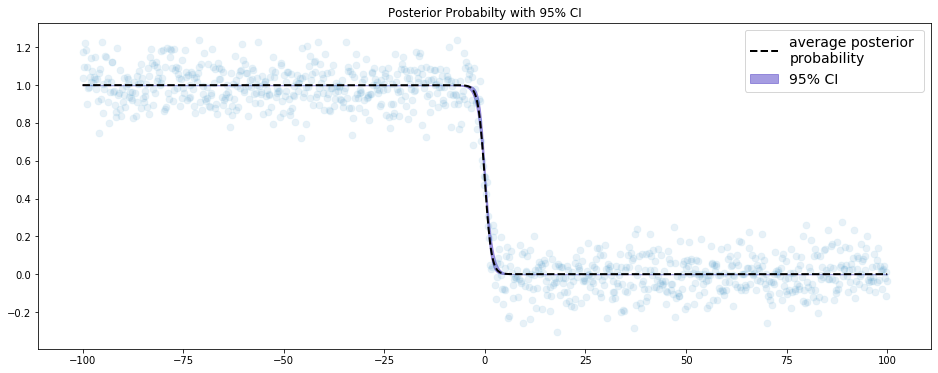

In [12]:
plt.fill_between(x, *quantiles, alpha=0.6, 
                 color='slateblue', label = '95% CI')
plt.plot(x, prob_est, lw=2, ls='--', 
         color='black', label="average posterior \nprobability")
plt.scatter(x, noisy_series, edgecolor = 'skyblue', s=50, alpha=0.1);
plt.legend(prop={'size':14})
plt.title('Posterior Probabilty with 95% CI');

# Diagnostics

## Trace plots

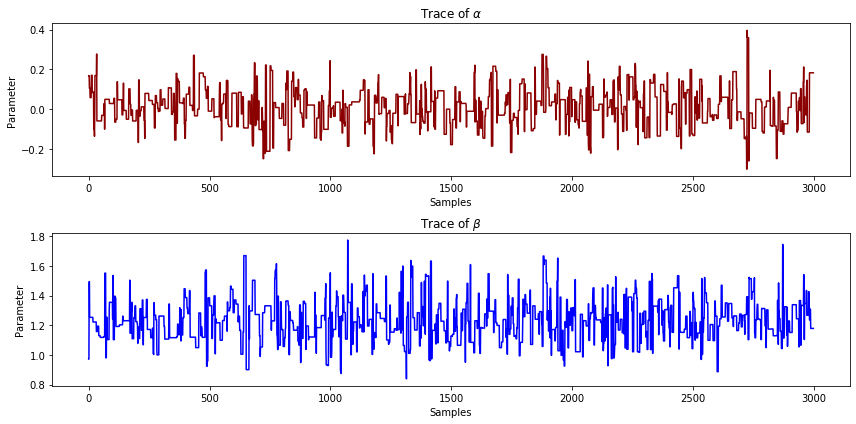

In [13]:
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)

### Built-in Diagnostics

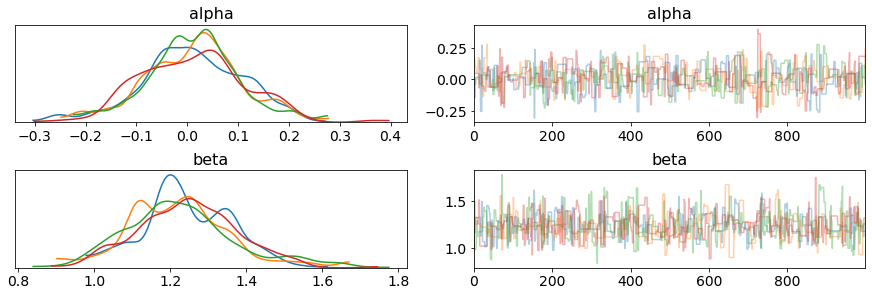

In [14]:
figsize(20, 12)
pm.traceplot(model_trace, ['alpha', 'beta']);

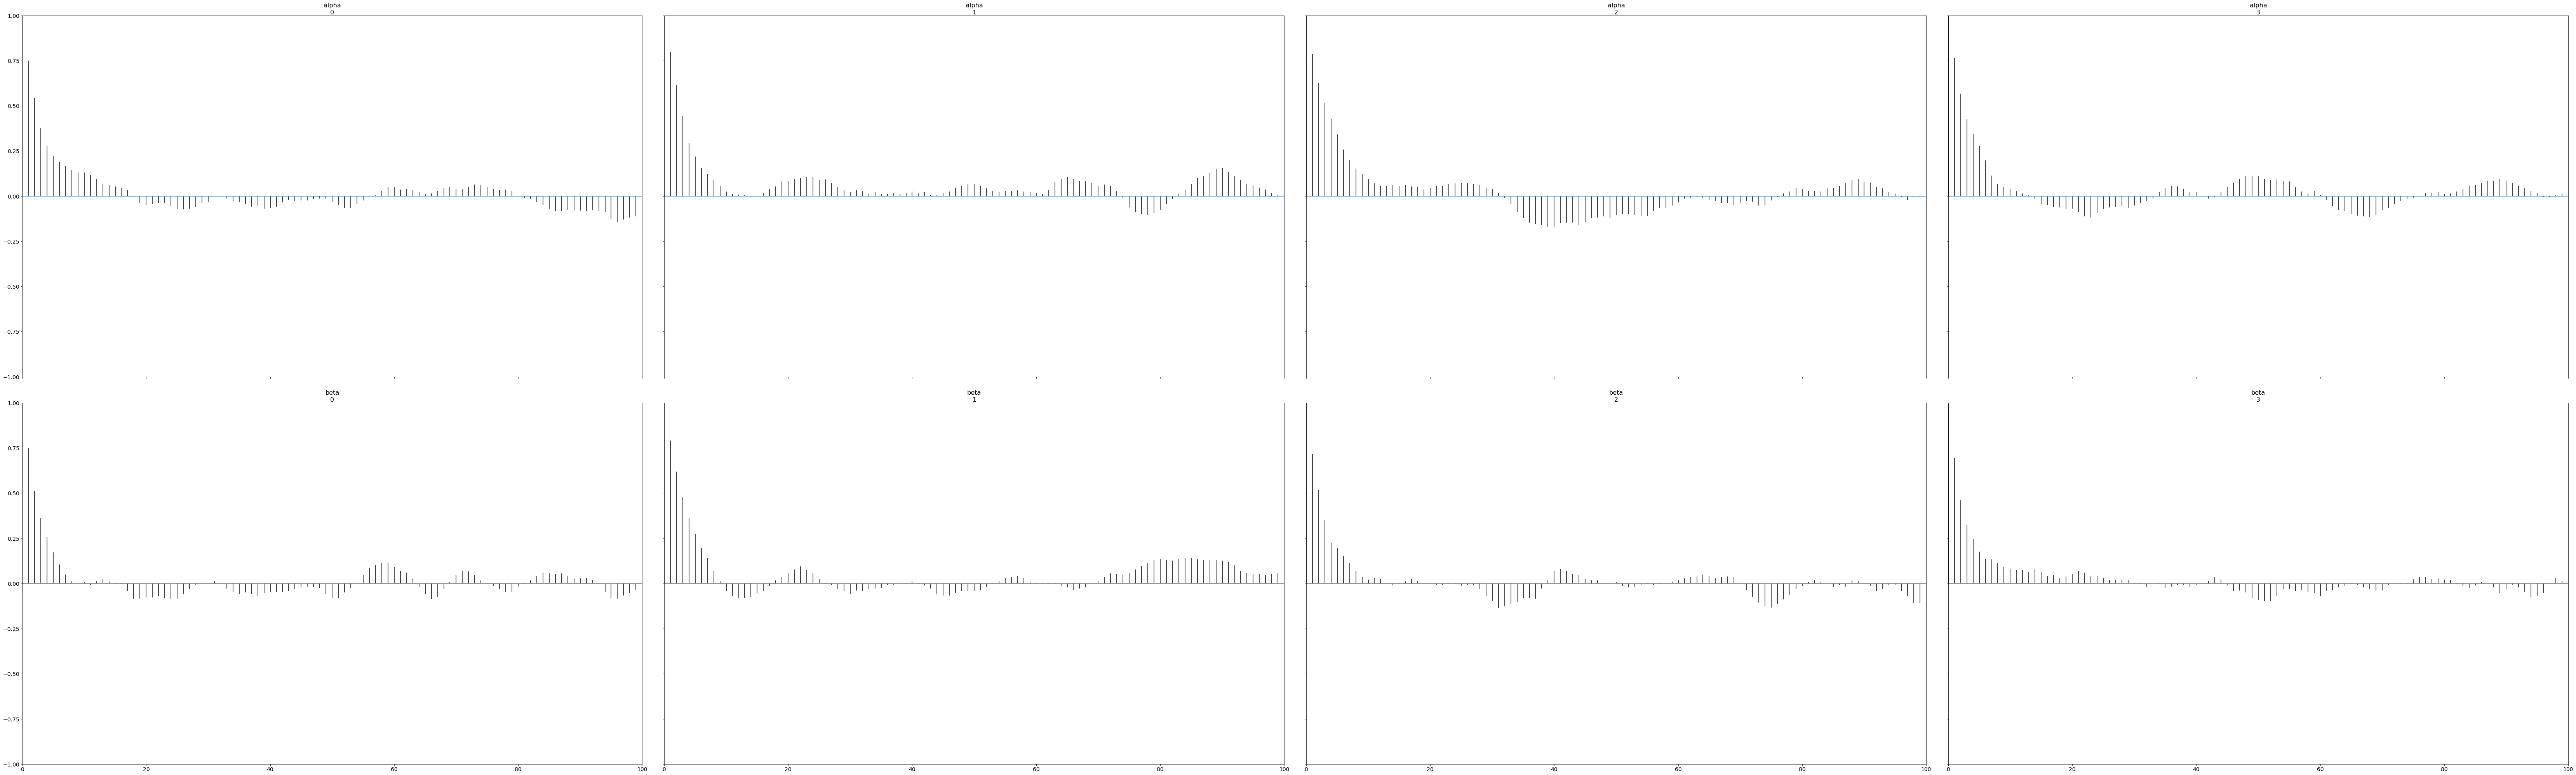

In [15]:
pm.autocorrplot(model_trace, ['alpha', 'beta']);

## Gelman-Rubin Diagnostic

The Gelman-Rubin diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.

Ref: https://docs.pymc.io/api/diagnostics.html

Scale reduction factors  close to 1 indicate probable convergence.

In [16]:
pm.diagnostics.gelman_rubin(model_trace, var_names = ['alpha','beta'])

{'alpha': 0.9996407656324432, 'beta': 1.004337467757901}

## Effective Sample Size

Returns estimate of the effective sample size of a set of traces.


In [17]:
pm.diagnostics.effective_n(model_trace, var_names = ['alpha','beta'])

{'alpha': 541.2386181114017, 'beta': 623.5992099048414}

## Model Selection

How does one select amongst various models? What are the criteria for selection?

See: https://docs.pymc.io/notebooks/model_comparison.html

__NB__: These criteria should be applied to two or more models for comparison, with lower values being preferred for a given model. 

### Deviance Information Criterion (DIC)

A typical model selection criterion. 

DIC (Spiegelhalter et al. 2002) is an information theoretic criterion for estimating predictive accuracy that is analogous to Akaike’s Information Criterion (AIC). It is a more Bayesian approach that allows for the modeling of random effects, replacing the maximum likelihood estimate with the posterior mean and using the effective number of parameters to correct for bias.

Ref: https://pymc3.readthedocs.io/en/latest/notebooks/model_comparison.html


In [18]:
 pm.dic(model_trace, MCMC_model)

AttributeError: module 'pymc3' has no attribute 'dic'

### Widely-applicable Information Criterion (WAIC)

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the computed log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting.

Ref: https://docs.pymc.io/notebooks/model_comparison.html

In [ ]:
model_waic = pm.waic(model_trace, MCMC_model)
model_waic.WAIC    

### Leave-one-out Cross-validation (LOO)

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples, which are corrected using Pareto-smoothed importance sampling (PSIS) to provide an estimate of point-wise out-of-sample prediction accuracy.

Ref: https://docs.pymc.io/notebooks/model_comparison.html

In [ ]:
model_loo = pm.loo(model_trace, MCMC_model)
model_loo.LOO

# Conclusions

 - For a good MCMC estimation of parameters, look for trace plots that show similar distributions and little fluctuation in parameter values as a function of MCMC sample number. 
 
 - The mean values of the prior distributions have a much greater effect on the quality of the MCMC estimates than the either the initial test values of variance of the prior distributions.